### Preparando arquivos

In [1]:
import os
from shutil import copyfile
import zipfile

def unzip_data(zip_file, data_dir):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(data_dir)


def create_data_dir(data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')
    val_dir = os.path.join(data_dir, 'val')
    if not os.path.exists(train_dir):
        os.mkdir(train_dir)
    if not os.path.exists(train_dir):
        os.mkdir(train_dir)
    if not os.path.exists(test_dir):
        os.mkdir(test_dir)
    if not os.path.exists(val_dir):
        os.mkdir(val_dir)
    return train_dir, test_dir, val_dir


def split_data(origin_dir, data_dir, train_dir, test_dir, val_dir, train_percentage, val_percentage):
    unzip_data(os.path.join('.', 'animals.zip'), os.path.join('.'))
    for c in os.listdir(origin_dir):
        class_size = len(os.listdir(os.path.join(origin_dir, c)))
        train_size = int(class_size * train_percentage)
        val_size = int(class_size * val_percentage)
        class_dir = os.path.join(origin_dir, c)
        if not os.path.exists(os.path.join(train_dir, c)):
            os.mkdir(os.path.join(train_dir, c))
        if not os.path.exists(os.path.join(val_dir, c)):
            os.mkdir(os.path.join(val_dir, c))
        if not os.path.exists(os.path.join(test_dir, c)):
            os.mkdir(os.path.join(test_dir, c))
        for i, img in enumerate(os.listdir(class_dir)):
            if i < train_size:
                if not os.path.exists(os.path.join(train_dir, c, img)):
                    copyfile(os.path.join(class_dir, img), os.path.join(train_dir, c, img))
            elif i < train_size + val_size:
                if not os.path.exists(os.path.join(val_dir, c, img)):
                    copyfile(os.path.join(class_dir, img), os.path.join(val_dir, c, img))
            else:
                if not os.path.exists(os.path.join(test_dir, c, img)):
                    copyfile(os.path.join(class_dir, img), os.path.join(test_dir, c, img))


def get_size_class(data_dir):
    for c in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, c)
        print(c, len(os.listdir(class_dir)))



ORIGIN_DIR=os.path.join('.', 'animals')
DATA_DIR=os.path.join('.', 'data')
TRAIN_DIR, TEST_DIR, VAL_DIR = create_data_dir(DATA_DIR)

split_data(ORIGIN_DIR, DATA_DIR, TRAIN_DIR, TEST_DIR, VAL_DIR, 0.7, 0.2)

print("Size of each class in origin data")
get_size_class(ORIGIN_DIR)
print("Size of each class in train data")
get_size_class(TRAIN_DIR)
print("Size of each class in val data")
get_size_class(VAL_DIR)
print("Size of test data")
print(len(os.listdir(TEST_DIR)))



Size of each class in origin data
cats 1000
dogs 1000
panda 1000
Size of each class in train data
cats 700
dogs 700
panda 700
Size of each class in val data
cats 200
dogs 200
panda 200
Size of test data
3


### Pré-processamento das imagens

In [2]:
#Definição das constantes
WIDTH = 160
HEIGHT = 160
COLOR_CHANNELS = 3
CHANNEL_SIZE = 255
IMAGE_SIZE = (WIDTH, HEIGHT)
IMAGE_SHAPE = IMAGE_SIZE + (COLOR_CHANNELS,)

BATCH_SIZE = 32
EPOCHS = 35
LEARNING_RATE = 0.00001

#Rescale images

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Loading Data com Normalização
train_datagen = ImageDataGenerator(rescale=1./CHANNEL_SIZE)
val_datagen = ImageDataGenerator(rescale=1./CHANNEL_SIZE)
test_datagen = ImageDataGenerator(rescale=1./CHANNEL_SIZE)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None         # No labels are returned for test dataset
)

import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

Found 2100 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

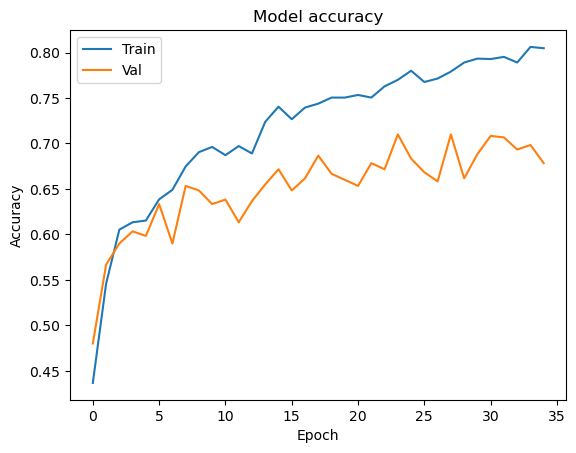

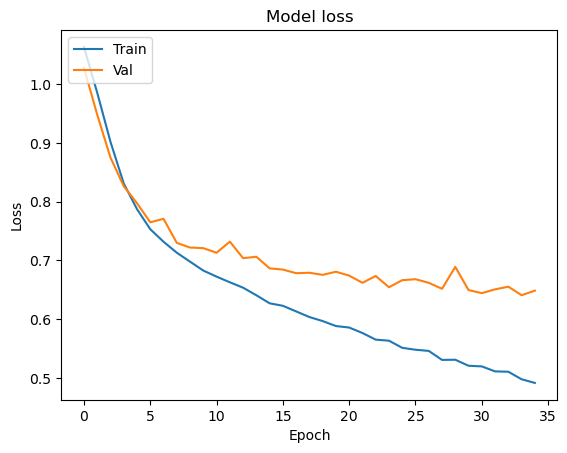

In [5]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=IMAGE_SHAPE), # Kernel size 3x3 com função de ativação relu
    MaxPooling2D(), # Pooling 2x2: reduz a dimensionalidade utilizando o valor máximo de cada janela 2x2
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),  # Camada densa com 128 neurônios com função de ativação relu
    Dense(3, activation='softmax')  # Camada densa com 3 neurônios com função de ativação softmax
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1,
    shuffle=True,
    max_queue_size=8,
)

plot_accuracy(history)
plot_loss(history)


In [6]:
predictions = model.predict(test_generator).argmax(axis=1)

print(predictions)

# Model metrics
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices.keys()))

print(confusion_matrix(test_generator.classes, predictions))

10/10 [==============================] - 4s 461ms/step
[0 1 2 1 1 1 2 2 1 2 0 1 1 1 2 1 2 1 1 1 2 1 2 0 2 2 2 2 2 0 1 0 0 2 2 2 1
 0 0 1 2 0 1 2 1 1 2 0 0 1 1 2 1 0 1 1 2 0 1 0 2 2 1 0 0 2 2 1 2 0 2 0 1 2
 1 2 2 1 1 2 2 2 1 2 2 1 1 0 0 2 2 1 2 2 1 1 0 1 1 1 0 0 1 2 1 1 0 1 1 1 1
 1 1 2 1 2 0 2 0 0 0 1 1 1 0 1 2 0 2 2 2 1 1 2 2 0 2 2 0 1 1 1 0 1 1 1 1 0
 2 0 0 1 1 1 1 1 1 1 0 2 1 1 0 1 0 0 1 0 2 2 1 0 2 1 0 2 2 2 0 1 1 1 1 2 1
 0 2 0 2 2 1 2 2 1 2 2 1 2 1 1 1 2 2 0 0 2 1 2 2 1 0 0 1 2 0 1 0 1 0 1 0 1
 1 1 1 0 2 2 1 0 1 2 1 1 1 1 1 2 0 1 1 2 1 2 2 1 2 1 1 2 1 2 2 2 1 1 1 0 2
 0 1 2 1 1 1 1 1 1 1 0 1 0 0 1 1 2 2 2 0 1 1 1 0 1 1 2 2 0 1 1 0 1 0 2 0 1
 2 0 2 1]
              precision    recall  f1-score   support

        cats       0.30      0.21      0.25       100
        dogs       0.34      0.46      0.39       100
       panda       0.29      0.28      0.29       100

    accuracy                           0.32       300
   macro avg       0.31      0.32      0.31       300
weighted 

Nota-se que a partir da 15ª epoca, o modelo começou a ter um distânciamento entre as curvas de treino e validação, o que indica que o modelo está começando a sofrer de overfitting. Para evitar isso, foram implementados dois métodos de regularização: Dropout e Data Augmentation.

In [7]:
train_datagen = ImageDataGenerator('data/train',
                                #    horizontal_flip=True,
                                #    rotation_range=20,
                                #    width_shift_range=0.2,
                                #    height_shift_range=0.2
                                   );
val_datagen = ImageDataGenerator('data/validation',
                                #    horizontal_flip=True,
                                #    rotation_range=20,
                                #    width_shift_range=0.2,
                                #    height_shift_range=0.2
                                   );
test_datagen = ImageDataGenerator(rescale=1./CHANNEL_SIZE);
# test_datagen = ImageDataGenerator(rescale=1./CHANNEL_SIZE,
#                                    horizontal_flip=True,
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2
#                                    );

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None         # No labels are returned for test dataset
)

Found 2100 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


Para o teste com Dropout e Data Augmentation, foi utilizado o modelo com 45 épocas e learning rate de 0.0001. Pois foi o modelo que apresentou o melhor resultado até o momento.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 64)      

c:\Users\hugos\anaconda3\envs\CIS\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/35
66/66 [==============================] - 30s 445ms/step - loss: 16.9310 - accuracy: 0.4110 - val_loss: 4.4842 - val_accuracy: 0.4967
Epoch 2/35
66/66 [==============================] - 25s 372ms/step - loss: 3.8010 - accuracy: 0.4967 - val_loss: 1.9198 - val_accuracy: 0.5083
Epoch 3/35
66/66 [==============================] - 24s 356ms/step - loss: 1.5216 - accuracy: 0.5010 - val_loss: 1.2245 - val_accuracy: 0.5033
Epoch 4/35
66/66 [==============================] - 26s 389ms/step - loss: 1.1513 - accuracy: 0.4981 - val_loss: 1.0915 - val_accuracy: 0.4933
Epoch 5/35
66/66 [==============================] - 25s 374ms/step - loss: 1.0086 - accuracy: 0.5362 - val_loss: 1.0040 - val_accuracy: 0.5517
Epoch 6/35
66/66 [==============================] - 26s 379ms/step - loss: 0.9391 - accuracy: 0.5629 - val_loss: 0.9557 - val_accuracy: 0.5650
Epoch 7/35
66/66 [==============================] - 23s 344ms/step - loss: 0.8867 - accuracy: 0.5686 - val_loss: 0.9225 - val_accuracy: 0.593

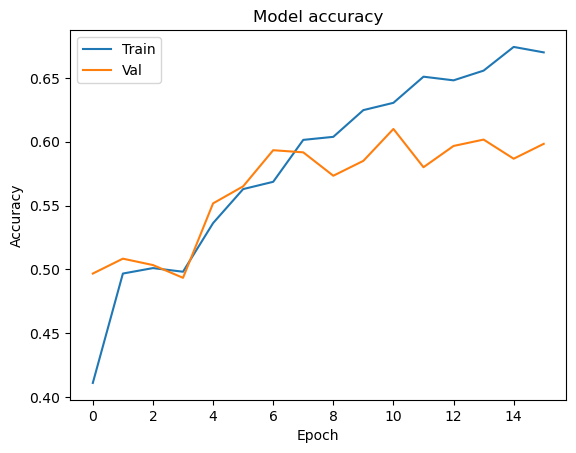

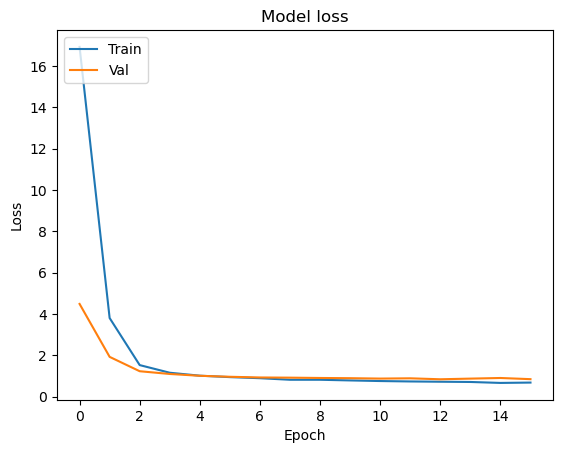

In [8]:
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

EPOCHS = 35
TRAIN_STEPS = 1000
VAL_STEPS = 400

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=IMAGE_SHAPE), # Kernel size 3x3 com função de ativação relu
    MaxPooling2D(), # Pooling 2x2: reduz a dimensionalidade utilizando o valor máximo de cada janela 2x2
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),  # Camada densa com 128 neurônios com função de ativação relu
    Dropout(0.2),
    Dense(3, activation='softmax')  # Camada densa com 3 neurônios com função de ativação softmax
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

plot_accuracy(history)
plot_loss(history)

In [9]:
predictions = model.predict(test_generator).argmax(axis=1)

print(predictions)

# Model metrics
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices.keys()))

print(confusion_matrix(test_generator.classes, predictions))

10/10 [==============================] - 2s 155ms/step
[0 0 1 0 1 0 1 0 1 0 2 1 1 0 1 2 2 2 1 0 2 2 1 0 0 0 1 1 2 0 2 2 0 1 0 1 1
 1 0 1 1 1 1 0 0 2 0 2 2 2 1 0 0 1 0 0 2 1 2 2 1 1 0 0 0 2 1 0 2 1 2 1 0 2
 2 1 1 1 1 1 0 2 0 0 0 1 2 2 1 1 1 0 1 1 2 1 1 1 1 0 2 1 2 0 2 0 0 1 2 2 1
 0 1 1 0 2 1 0 2 0 2 2 2 0 1 2 0 1 2 1 1 2 1 1 1 2 2 2 1 2 2 2 1 1 2 0 0 0
 1 1 1 1 2 1 0 0 1 2 1 1 1 2 0 1 2 1 2 0 1 1 2 1 0 2 0 2 0 1 2 2 1 2 1 2 0
 2 0 1 1 2 1 1 1 0 0 2 1 0 0 2 1 0 1 1 0 1 2 0 0 1 2 0 1 2 2 0 2 0 0 0 0 0
 2 0 1 1 2 1 1 1 2 1 1 1 0 0 1 0 0 1 0 0 0 0 0 2 0 1 1 1 0 1 1 1 2 0 0 0 0
 2 2 0 0 2 2 0 0 1 0 0 2 0 2 2 1 0 1 0 1 0 2 1 0 2 1 0 2 2 2 1 0 2 2 2 0 2
 2 2 0 0]
              precision    recall  f1-score   support

        cats       0.33      0.33      0.33       100
        dogs       0.35      0.39      0.37       100
       panda       0.31      0.28      0.30       100

    accuracy                           0.33       300
   macro avg       0.33      0.33      0.33       300
weighted 

Com a implementação da regularização por dropout no modelo foi possível visualizar que o mesmo atingiu um nível de 